# Solving a stiff differential equation with a deep neural net
Written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)

## The problem

Consider the following first order differential equation:

$\frac{d y(t)}{dt} = g(y,t) = -21 y(t)+ e^{-t}$

$y(0) = 0.0$

The example is taken from these [notes](https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/14IVPs/stiff/complete.html). Note that this problem has an analytical solution of the form  $y(t) = A e^{-st}+ y_p(t)$, where $y_p(t)$ is the particular solution. So let's solve it, after a bit of algebra we get:

$y(t) = 0.05 \big( e^{-t} - e^{-21 t}\big)$

### Let's plot the theoretical solution  

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
fontsize= 18
ticksize = 14
figsize = (7, 4.5)
params = {"text.usetex": True,
    'font.family':'serif',
    "figure.figsize":figsize, 
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize, 
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params) 

In [3]:
class params:
    def __init__(self,
                 α = -21,
                 β = -1.0,
                 y_0 = 0.0,
                 T = 4,
                ):
        self.α = α
        self.β = β
        self.y_0 = y_0
        self.T = T

In [4]:
def theory_sol(time):
    α = params().α
    β = params().β
    return 0.05*(-torch.exp(α*time)+ torch.exp(β*time))

In [5]:
time_mesh = torch.arange(0.0, params().T , 0.005)
dim = time_mesh.shape[0]
time_mesh = time_mesh.reshape([dim,1])
y_theory = theory_sol(time_mesh)

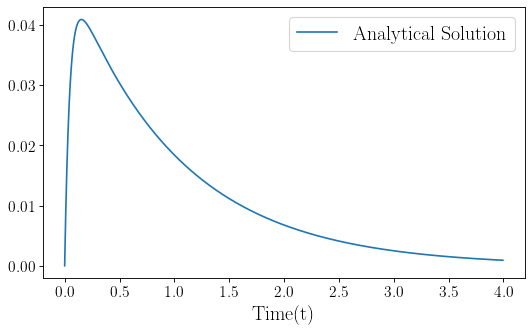

In [6]:
plt.plot(time_mesh,y_theory,label= r"Analytical Solution")
plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.show()


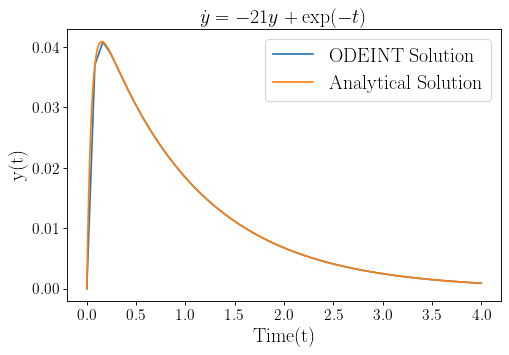

In [7]:
from scipy.integrate import odeint
def g_1(y,t):
    α = params().α
    β = params().β
    dydt = α * y + np.exp(β*t)
    return dydt

y0 = 0.0

# time points
time_1 = np.linspace(0,params().T)

# solve ODE
y_1 = odeint(g_1,y0,time_1)

# plot results
plt.plot(time_1,y_1, label = r"ODEINT Solution")
plt.plot(time_mesh,y_theory,label= r"Analytical Solution")
plt.title(r"$\dot{y} = -21y+\exp(-t)$")
plt.xlabel('Time(t)')
plt.ylabel('y(t)')
plt.legend(loc='best')

plt.show()

In [8]:
print("ODEINT uses",time_1.shape[0], "data points")

ODEINT uses 50 data points


## Solving the problem with a DNN

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
class Collocation_data:
    def __init__(self,
                 mesh_step = 0.08,
                 batch_size = 4,
                ):
        
        
        self.T = params().T
        self.mesh_step = mesh_step
        self.batch_size = batch_size
    
        self.time_range = torch.arange(start = 0.0, end = self.T , step = self.mesh_step)
        dim = self.time_range.shape[0]
        self.time = self.time_range.reshape([dim,1])

### Writing the dataloader

In [11]:
class Data_label(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.time = self.data[:,[0]]
        self.n_samples = self.data.shape[0]
    
    def __getitem__(self,index):
        #first element is time, second element is y
            return self.time[index]
        
    def __len__(self):
        return self.n_samples

In [12]:
train_data = Collocation_data().time
train_labeled = Data_label(train_data)
batch_len = Collocation_data().batch_size
train = DataLoader(dataset = train_labeled, batch_size = batch_len , shuffle = True )

In [13]:
epsilon = 1e-8
np.sqrt(epsilon)

0.0001

Here I am going to use an old trick introduced by [Lagaris, Likas, and Fotiadis](https://arxiv.org/pdf/physics/9705023.pdf), equation 11. The trick is essentially representing the solution by :

$y(t) = y_0 + t\tilde{y}(t)$

Note that:

(1) $y(0) = y_0$

(2) $\tilde{y}$ is going to be approximated by a neural net

### Setting up the neuran net and some useful functions

In [14]:
def y(model,t):
    y_0 = params().y_0
    return y_0+t*model(t)

In [15]:
def derivative_forward(model,t): #forward differencing: dy/t
    sqrt_eps = np.sqrt(epsilon)
    return (y(model,t+sqrt_eps)-y(model,t))/sqrt_eps

In [16]:
def derivative_back(model,t): #backward differencing : dy/dt
    sqrt_eps = np.sqrt(epsilon)
    return (y(model,t)-y(model,t-sqrt_eps))/sqrt_eps


In [17]:
def derivative_center(model,t): #centered differencing : This sucks
    sqrt_eps = np.sqrt(epsilon)
    return (y(model,t+sqrt_eps)-y(model,t-sqrt_eps))/2*sqrt_eps


In [18]:
def f(model,t): # f(y,t)
    α = params().α
    β = params().β
    dfdt = α * y(model,t) + torch.exp(β*t)
    return dfdt

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

### Defining the neural network

In [20]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())  
            
        module.append(nn.Linear(self.dim_hidden,1))
        module.append(nn.Softplus(beta = 1.0))
        
        self.y = nn.Sequential(*module)


    def forward(self, x):
        out = self.y(x)
        return  out

### Training 

In [21]:
model= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [22]:
num_epochs = 2501

In [23]:
for epoch in range(num_epochs):
    for i, time in enumerate(train):
        res =  derivative_back(model,time) - f(model,time)
        
        loss = res.pow(2).mean()
                
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    scheduler.step()
    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',' , 'lr_rate')
    if epoch % 100 == 0:
          print(epoch,',',"{:.2e}".format(loss.item()),',', "{:.2e}".format(get_lr(optimizer)) )  
        

epoch , loss , lr_rate
0 , 2.02e-01 , 1.00e-03
100 , 4.00e-02 , 8.00e-04
200 , 3.36e-03 , 6.40e-04
300 , 8.27e-04 , 5.12e-04
400 , 1.25e-03 , 4.10e-04
500 , 2.94e-02 , 3.28e-04
600 , 9.95e-05 , 2.62e-04
700 , 8.24e-05 , 2.10e-04
800 , 1.23e-04 , 1.68e-04
900 , 1.53e-05 , 1.34e-04
1000 , 1.46e-05 , 1.07e-04
1100 , 2.01e-04 , 8.59e-05
1200 , 2.62e-04 , 6.87e-05
1300 , 5.31e-05 , 5.50e-05
1400 , 3.58e-06 , 4.40e-05
1500 , 5.45e-05 , 3.52e-05
1600 , 1.71e-05 , 2.81e-05
1700 , 1.79e-07 , 2.25e-05
1800 , 1.78e-06 , 1.80e-05
1900 , 2.61e-06 , 1.44e-05
2000 , 3.06e-06 , 1.15e-05
2100 , 2.06e-05 , 9.22e-06
2200 , 2.37e-07 , 7.38e-06
2300 , 5.67e-07 , 5.90e-06
2400 , 2.20e-07 , 4.72e-06
2500 , 1.60e-06 , 3.78e-06


In [24]:
model.eval()

NN(
  (y): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Softplus(beta=1.0, threshold=20)
  )
)

In [25]:
time_tensor = Collocation_data(mesh_step = 0.005).time
y_approx = y(model,time_tensor).detach()

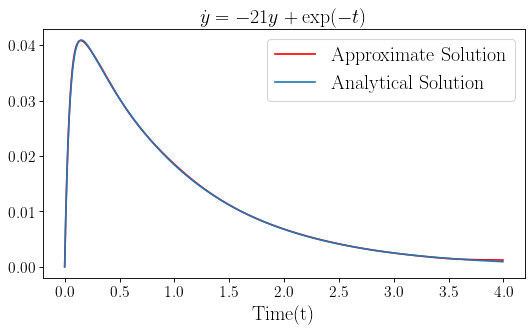

In [26]:
plt.plot(time_tensor, y_approx, color = 'r' ,label= r"Approximate Solution")
plt.plot(time_mesh,y_theory, label= r"Analytical Solution")
#plt.plot(time_1,y_1, label = r"ODEINT Solution")
plt.title(r"$\dot{y} = -21y+\exp(-t)$")

plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

## Plotting the GIF:

In [32]:
model= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [33]:
num_epochs = 2500
gif_results = torch.zeros([time_tensor.shape[0],250])

In [34]:
j = 0
for epoch in range(num_epochs):
    if epoch % 10 ==0:
        gif_results[:,j] = y(model,time_tensor).detach().squeeze()
        j = j+1
    for i, time in enumerate(train):
        res =  derivative_back(model,time) - f(model,time)
        
        loss = res.pow(2).mean()
                
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    scheduler.step()
    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',' , 'lr_rate')
    if epoch % 100 == 0:
          print(epoch,',',"{:.2e}".format(loss.item()),',', "{:.2e}".format(get_lr(optimizer)) )  
        

epoch , loss , lr_rate
0 , 2.02e-01 , 1.00e-03
100 , 4.00e-02 , 8.00e-04
200 , 3.36e-03 , 6.40e-04
300 , 8.27e-04 , 5.12e-04
400 , 1.25e-03 , 4.10e-04
500 , 2.94e-02 , 3.28e-04
600 , 9.95e-05 , 2.62e-04
700 , 8.24e-05 , 2.10e-04
800 , 1.23e-04 , 1.68e-04
900 , 1.53e-05 , 1.34e-04
1000 , 1.46e-05 , 1.07e-04
1100 , 2.01e-04 , 8.59e-05
1200 , 2.62e-04 , 6.87e-05
1300 , 5.31e-05 , 5.50e-05
1400 , 3.58e-06 , 4.40e-05
1500 , 5.45e-05 , 3.52e-05
1600 , 1.71e-05 , 2.81e-05
1700 , 1.79e-07 , 2.25e-05
1800 , 1.78e-06 , 1.80e-05
1900 , 2.61e-06 , 1.44e-05
2000 , 3.06e-06 , 1.15e-05
2100 , 2.06e-05 , 9.22e-06
2200 , 2.37e-07 , 7.38e-06
2300 , 5.67e-07 , 5.90e-06
2400 , 2.20e-07 , 4.72e-06


In [35]:
import os
import matplotlib.pyplot as plt
import imageio

In [36]:
filenames = []
for i in range(gif_results.shape[1]):
    # plot the line chart
    plt.plot(time_tensor,gif_results[:,i], color= 'b',label= r"Approximate Solution" )
    plt.plot(time_mesh,y_theory, "--", color= 'r', label= r"Analytical Solution")
    plt.title(r"$\dot{y} = -21y+\exp(-t)$")
    plt.ylabel(r"$y(t)$")
    plt.xlabel(r"Time(t)")
    plt.legend(loc='upper right')
    plt.ylim(0.0,0.06)
    plt.xlim(-0.05,4)
    plt.tight_layout()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('stiff.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)